In [19]:
import os, sys
# insert parent directory at beginning of python search path
from pathlib import Path
current_path = os.getcwd()
parent_path = str(Path(current_path).parent)
sys.path.append(parent_path)

import numpy as np
from scipy.integrate import solve_ivp
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

# from src.particle_filter import ParticleFilter
from src.utils import rk4, atleast_col_vector, set_axes_equal
from src.particle_filter import ParticleFilter
from src.hybrid_extended_kalman_filter import HybridExtendedKalmanFilter
from src.discrete_linear_kalman_filter import DiscreteLinearKalmanFilter
from src.discrete_unscented_kalman_filter import DiscreteUnscentedKalmanFilter

In [20]:
import numpy as np

def rab2xyz(rho, alpha, beta):
    R = rho * np.cos(beta)
    x = R * np.cos(alpha)
    y = np.sqrt(R**2 - x**2)
    z = np.sqrt(rho**2 - x**2 - y**2)

    xyz = np.array([x, y, z])
    return xyz

def f(X, u, w, t, params):
    rho0 = params['rho0']
    Cd = params['Cd']
    Ap = params['Ap']
    m = params['m']
    g = params['g']
    omega = params['omega']
    S = params['S']

    omegax, omegay, omegaz = omega

    D = 0.5 * Cd * Ap * rho0

    x, y, z, xdot, ydot, zdot = X

    xdot1 = xdot
    xdot2 = ydot
    xdot3 = zdot
    xdot4 = -D/m * xdot**2 + S/m*omegay * zdot - S/m*omegaz * ydot
    xdot5 = -D/m * ydot**2 + S/m*omegaz * xdot - S/m*omegax * zdot
    xdot6 = -D/m * zdot**2 + S/m*omegax * ydot - S/m*omegay * xdot - g
    
    xdot = np.array([xdot1, xdot2, xdot3, xdot4, xdot5, xdot6])
    return xdot

def fdis(x, u, w, t, params):
    dt = params['dt']
    infunc = lambda int, inx: f(inx, u, w, int, params)
    out = rk4(infunc, t, dt, x)
    return out

def f_wo_magnus(X, u, w, t, params):
    rho0 = params['rho0']
    Cd = params['Cd']
    Ap = params['Ap']
    m = params['m']
    g = params['g']
    omega = params['omega']
    S = 0

    omegax, omegay, omegaz = omega

    D = 0.5 * Cd * Ap * rho0

    x, y, z, xdot, ydot, zdot = X

    xdot1 = xdot
    xdot2 = ydot
    xdot3 = zdot
    xdot4 = -D/m * xdot**2 + S/m*omegay * zdot - S/m*omegaz * ydot
    xdot5 = -D/m * ydot**2 + S/m*omegaz * xdot - S/m*omegax * zdot
    xdot6 = -D/m * zdot**2 + S/m*omegax * ydot - S/m*omegay * xdot - g
    
    out = np.array([xdot1, xdot2, xdot3, xdot4, xdot5, xdot6])
    return out 

def f_wo_magnus_and_drag(X, u, w, t, params):
    rho0 = params['rho0']
    Cd = 0
    Ap = params['Ap']
    m = params['m']
    g = params['g']
    omega = params['omega']
    S = 0

    omegax, omegay, omegaz = omega

    D = 0.5 * Cd * Ap * rho0

    x, y, z, xdot, ydot, zdot = X

    xdot1 = xdot
    xdot2 = ydot
    xdot3 = zdot
    xdot4 = -D/m * xdot**2 + S/m*omegay * zdot - S/m*omegaz * ydot
    xdot5 = -D/m * ydot**2 + S/m*omegaz * xdot - S/m*omegax * zdot
    xdot6 = -D/m * zdot**2 + S/m*omegax * ydot - S/m*omegay * xdot - g
    
    out = np.array([xdot1, xdot2, xdot3, xdot4, xdot5, xdot6])
    return out

def h(X, w, t, params):
    x, y, z, _, _, _ = X

    rho = np.sqrt(x**2 + y**2 + z**2)
    R = np.sqrt(x**2 + y**2)
    alpha = np.arccos(x/R)
    beta = np.arccos(R/rho)

    z = np.array([rho, alpha, beta])
    return z

def Afunc(X, u, t, params):
    rho0 = params['rho0']
    Cd = 0
    Ap = params['Ap']
    m = params['m']
    g = params['g']
    omega = params['omega']
    S = 0

    omegax, omegay, omegaz = omega

    D = 0.5 * Cd * Ap * rho0

    x, y, z, xdot, ydot, zdot = X
    xdot = xdot.item(0)
    ydot = ydot.item(0)
    zdot = zdot.item(0)

    A44 = -2*D/m*xdot
    A45 = -S/m*omegaz
    A46 = S/m*omegay

    A54 = S/m*omegaz
    A55 = -2*D/m*ydot
    A56 = -S/m*omegax
    
    A64 = -S/m*omegay
    A65 = S/m*omegax
    A66 = -2*D/m*zdot

    Jac = np.array([[0, 0, 0, 1, 0, 0],
                    [0, 0, 0, 0, 1, 0],
                    [0, 0, 0, 0, 0, 1],
                    [0, 0, 0, A44, A45, A46],
                    [0, 0, 0, A54, A55, A56],
                    [0, 0, 0, A64, A65, A66]])
    return Jac

def Lfunc(x, u, t, params):
    Jac = np.eye(6)
    return Jac

def Hfunc(X, u, t, params):
    x = X[0]
    y = X[1]
    z = X[2]
    x = x.item(0)
    y = y.item(0)
    z = z.item(0)

    R = np.sqrt(x**2 + y**2)
    rho = np.sqrt(x**2 + y**2 + z**2)

    num3 = x**2 + y**2 + z**2
    num4 = x**2 + y**2
    num1 = np.sqrt(1 - num4 / num3)
    num2 = np.sqrt(1 - x**2 / num4)

    H21 = - ((1 / np.sqrt(num4)) - x**2 / (num4)**(3 / 2)) / num2
    H22 = (x * y) / (num2 * (num4)**(3 / 2))
    H31 = - (x / (np.sqrt(4) * np.sqrt(3)) - (x * np.sqrt(4)) / (num3**(3 / 2))) / num1
    H32 = - (y / (np.sqrt(num4) * np.sqrt(num3)) - (y * np.sqrt(num4)) / (num3**(3 / 2))) / num1
    H33 = z * np.sqrt(num4) / (num1 * num3**(3 / 2))

    H = np.array([[x / np.sqrt(3), y / np.sqrt(3), z / np.sqrt(3), 0, 0, 0],
                  [H21, H22, 0, 0, 0, 0],
                  [H31, H32, H33, 0, 0, 0]])
    return H

def Mfunc(x, u, t, params):
    Jac = np.eye(3)
    return Jac


In [21]:
import numpy as np
from scipy.linalg import expm

# Read data from file (assuming data_updated_2024-03-13.txt contains relevant data)
data = np.loadtxt("test_data/data_updated_2024-03-13.txt")

# Parameters
Cd = 0.2
d = 0.04267
rho0 = 1.293
S = 0.000025
Ap = 2 * (d**2) / 4
omega = np.array([250, 0, 0])
m = 0.04593
g = 9.80665

# Uncertainty parameters
rho_sigma = 0.9144 / 3
alpha_sigma = 0.00174533 / 3
beta_sigma = 0.00174533 / 3
Q = 1e-9 * np.eye(6)
R = np.array([[rho_sigma, 0, 0],
              [0, alpha_sigma, 0],
              [0, 0, beta_sigma]])

# Time parameters
t = data[:, 0]
tstart = np.array([0])
dt = t[1] - t[0]
tspan = np.concatenate((tstart, t))

params = {
    'rho0': rho0,
    'Cd': Cd,
    'Ap': Ap,
    'm': m,
    'g': g,
    'omega': omega,
    'S': S,
    'dt': dt

}

# Initial conditions
x0 = np.array([0.01, 0.02, 0.03, 0.0, 70.43, 15.0]).reshape(-1, 1)
P0 = 0.1 * np.eye(6)
u = np.atleast_2d(0)

# Create Hybrid EKF object (you need to implement the functions f, h, Afunc, Lfunc, Hfunc, Mfunc)
ekf = HybridExtendedKalmanFilter(f, h, Q, R, x0, P0, tstart, Afunc, Lfunc, Hfunc, Mfunc)

# Create discrete UKF object (you need to implement the functions fdis, h)
ukf = DiscreteUnscentedKalmanFilter(fdis, h, Q, R, x0, P0)

# Create PF object (you need to implement the functions fdis, h)
x0_pdf = multivariate_normal(x0.flatten(), P0)
process_noise_pdf = multivariate_normal(np.zeros(6), Q)
pfParams = {'K': 0.2}
N = 1000
pf = ParticleFilter(fdis, h, R, N, x0_pdf, process_noise_pdf, pfParams)

# Create Discrete LKF object (you need to implement the functions Afunc, Hfunc)
A = Afunc(x0, u, tstart, params)
F = expm(A * dt)
G = np.zeros((6,1))
H = Hfunc(x0, u, tstart, params)
lkf = DiscreteLinearKalmanFilter(F, G, H, Q, R, x0, P0)

In [22]:
from tqdm import tqdm

# Simulate LKF and EKF
xdim=  x0.shape[0]
tdim = data[:, 0].shape[0]
dStore = {
    'PF' : {'x': np.zeros((xdim,tdim)), 'xhat': np.zeros((xdim,tdim)), 'P': P0},
    'EKF' : {'x': np.zeros((xdim,tdim)), 'xhat': np.zeros((xdim,tdim)), 'P': P0},
    'UKF' : {'x': np.zeros((xdim,tdim)), 'xhat': np.zeros((xdim,tdim)), 'P': P0},
    'LKF' : {'x': np.zeros((xdim,tdim)), 'xhat': np.zeros((xdim,tdim)), 'P': P0},
    'LUMVE' : {'x': np.zeros((xdim,tdim)), 'xhat': np.zeros((xdim,tdim)), 'P': P0},
   }
x = x0

# Create a progress bar using tqdm
progress_bar = tqdm(total=len(data[:, 0]), desc="Progress")

for i, t in enumerate(data[:, 0]):
    # Collect the measurement
    t = data[i, 0]
    rho = data[i, 1]
    beta = data[i, 2]
    alpha = data[i, 3]
    z = np.array([rho, beta, alpha]).reshape(-1, 1)

    # Simulate the continuous-time part of the HEKF
    ekf.predict(u, t, params)

    # Simulate the discrete-time part of the HEKF
    ekf.update(z, u, t, params)

    # # Simulate the predict step for LKF
    lkf.predict(u)

    # # Simulate the update step for LKF
    lkf.update(z, u, params)

    # # Simulate the predict step for UKF
    ukf.predict(u, t, params)

    # # Simulate the update step for UKF
    ukf.update(z, u, t, params)

    # # Simulate the step part of the PF
    pf.step(z, u, t, params)

    # Save data for plotting
    # dStore['truth']['x'][:,i] = ekf.x_hat
    dStore['EKF']['x'][:,i] = ekf.x_hat.flatten()
    dStore['LKF']['x'][:,i] = lkf.x_hat_plus.flatten()
    dStore['UKF']['x'][:,i] = ukf.x_hat.flatten()
    dStore['PF']['x'][:,i] = pf.x_hat.flatten()

    progress_bar.update(1)

progress_bar.close()


Progress: 100%|██████████| 25/25 [00:08<00:00,  2.97it/s]


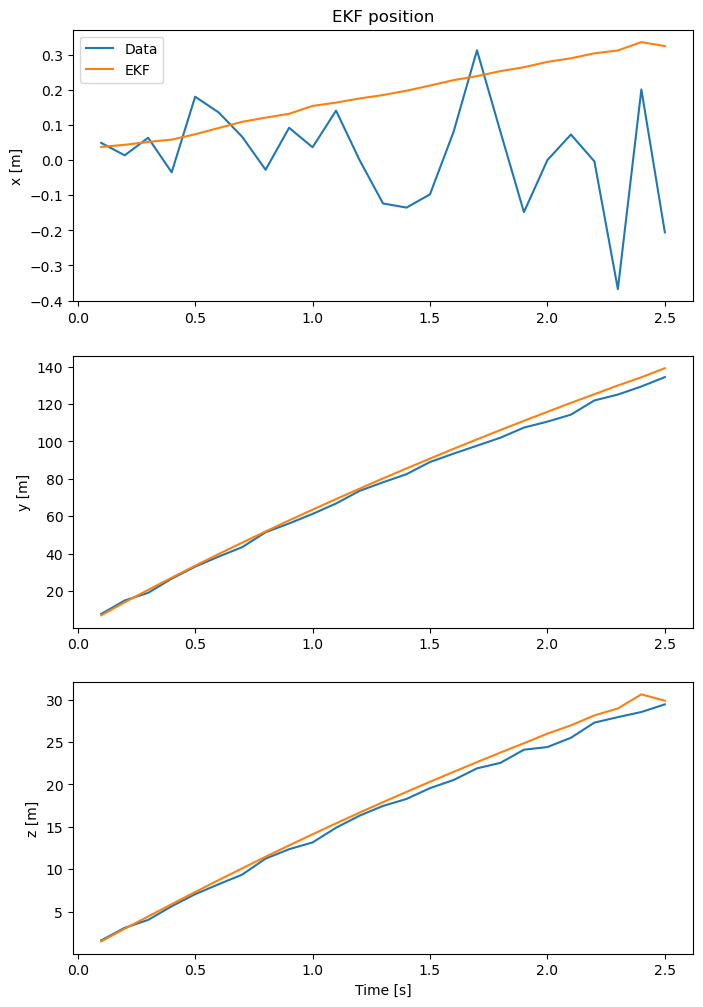

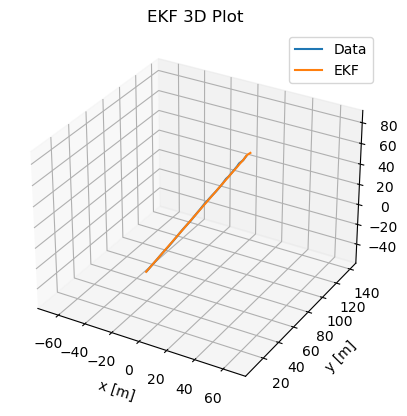

In [23]:
# get EKF data
xEKF = dStore['EKF']['x']
# get LKF data
xLKF = dStore['LKF']['x']
# get LUMVE data
xLUMVE = dStore['EKF']['x'].T
# get UKF data
xUKF = dStore['UKF']['x']
# get PF data
xPF = dStore['PF']['x']

plot_ekf_flag = True
plot_lkf_flag = True
plot_lumve_flag = True
plot_ukf_flag = True
plot_pf_flag = True

# Plots

# Transform rho, alpha, beta back into x, y, z
xyz = rab2xyz(data[:, 1], data[:, 2], data[:, 3])
x, y, z = xyz[0, :], xyz[1, :], xyz[2, :]
t = data[:, 0]

if plot_ekf_flag:
    # ----- Plot EKF -----
    # Create subplots
    fig, axs = plt.subplots(3, 1, figsize=(8, 12))

    # Plot x, y, z
    axs[0].plot(t, x, label="Data")
    axs[0].plot(t, xEKF[0, :], label="EKF")
    axs[0].set_title("EKF position")
    axs[0].set_ylabel("x [m]")
    axs[0].legend()

    axs[1].plot(t, y)
    axs[1].plot(t, xEKF[1, :])
    axs[1].set_ylabel("y [m]")

    axs[2].plot(t, z)
    axs[2].plot(t, xEKF[2, :])
    axs[2].set_ylabel("z [m]")
    axs[2].set_xlabel("Time [s]")

    # Save the figure
    # plt.savefig("figures/problem2_EKF_plots.png")

    # Plot 3D trajectory
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.plot(x, y, z, label="Data")
    ax.plot(xEKF[0, :], xEKF[1, :], xEKF[2, :], label="EKF")
    ax.set_title("EKF 3D Plot")
    ax.set_xlabel("x [m]")
    ax.set_ylabel("y [m]")
    ax.set_zlabel("z [m]")
    set_axes_equal(ax)
    ax.legend()

    # Save the 3D plot
    # plt.savefig("figures/problem2_EKF_3d.png")

    # Show the plots
    plt.show()

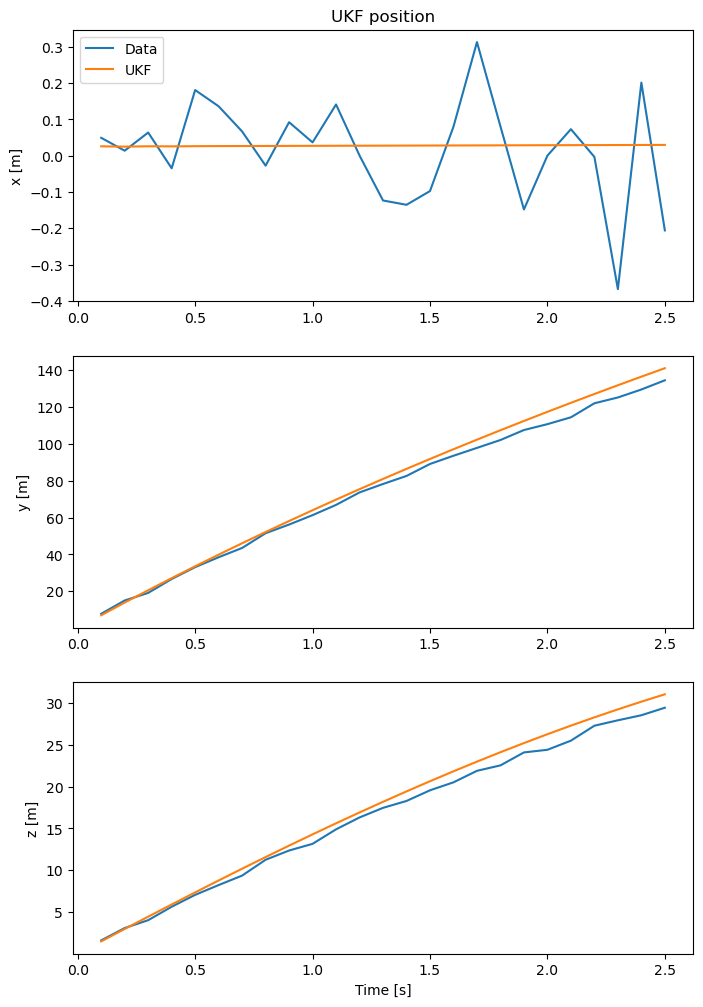

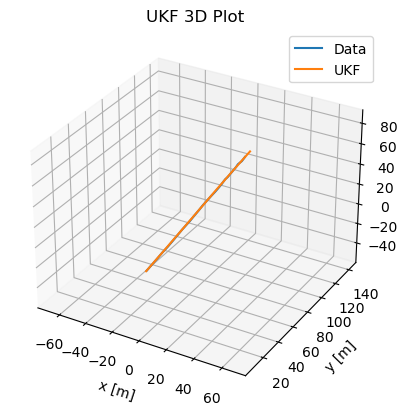

In [24]:

if plot_ukf_flag:
    # ----- Plot UKF -----
    # Create subplots
    fig, axs = plt.subplots(3, 1, figsize=(8, 12))

    # Plot x, y, z
    axs[0].plot(t, x, label="Data")
    axs[0].plot(t, xUKF[0, :], label="UKF")
    axs[0].set_title("UKF position")
    axs[0].set_ylabel("x [m]")
    axs[0].legend()

    axs[1].plot(t, y)
    axs[1].plot(t, xUKF[1, :])
    axs[1].set_ylabel("y [m]")

    axs[2].plot(t, z)
    axs[2].plot(t, xUKF[2, :])
    axs[2].set_ylabel("z [m]")
    axs[2].set_xlabel("Time [s]")

    # Save the figure
    # plt.savefig("figures/problem2_UKF_plots.png")

    # Plot 3D trajectory
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.plot(x, y, z, label="Data")
    ax.plot(xUKF[0, :], xUKF[1, :], xUKF[2, :], label="UKF")
    ax.set_title("UKF 3D Plot")
    ax.set_xlabel("x [m]")
    ax.set_ylabel("y [m]")
    ax.set_zlabel("z [m]")
    set_axes_equal(ax)
    ax.legend()

    # Save the 3D plot
    # plt.savefig("figures/problem2_UKF_3d.png")

    # Show the plots
    plt.show()

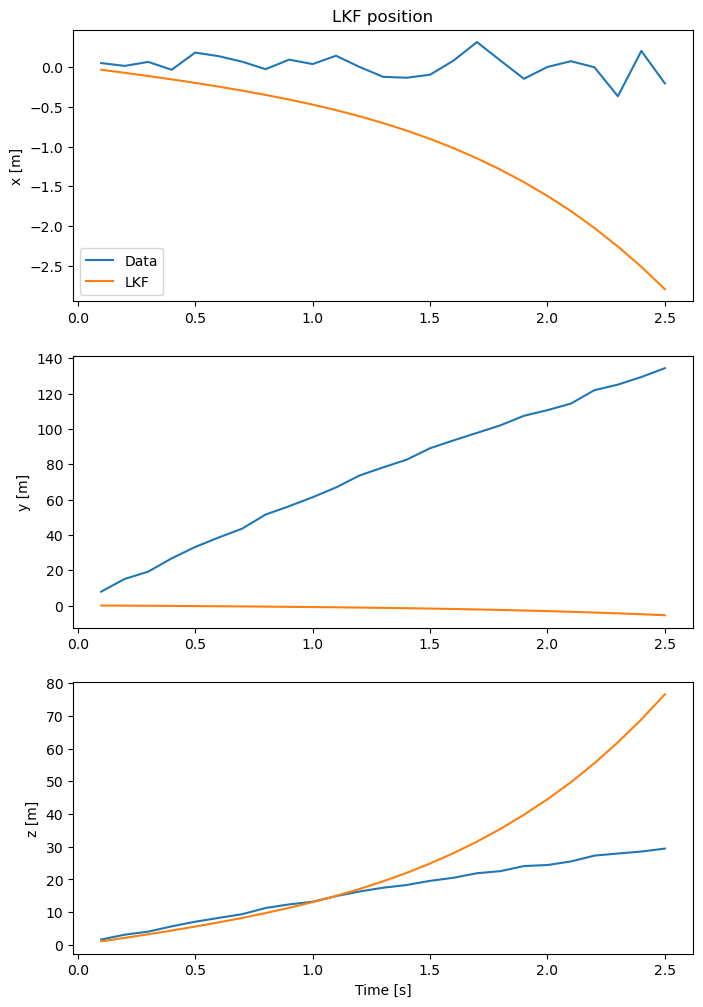

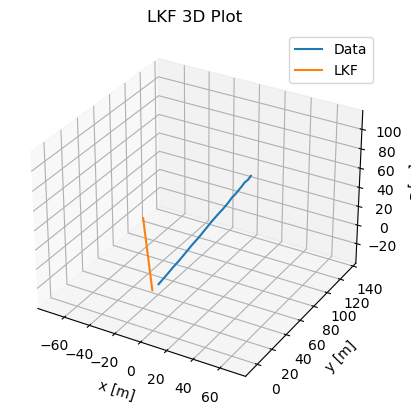

In [25]:

if plot_lkf_flag:
    # ----- Plot LKF -----
    # Create subplots
    fig, axs = plt.subplots(3, 1, figsize=(8, 12))

    # Plot x, y, z
    axs[0].plot(t, x, label="Data")
    axs[0].plot(t, xLKF[0, :], label="LKF")
    axs[0].set_title("LKF position")
    axs[0].set_ylabel("x [m]")
    axs[0].legend()

    axs[1].plot(t, y)
    axs[1].plot(t, xLKF[1, :])
    axs[1].set_ylabel("y [m]")

    axs[2].plot(t, z)
    axs[2].plot(t, xLKF[2, :])
    axs[2].set_ylabel("z [m]")
    axs[2].set_xlabel("Time [s]")

    # Save the figure
    # plt.savefig("figures/problem2_LKF_plots.png")

    # Plot 3D trajectory
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.plot(x, y, z, label="Data")
    ax.plot(xLKF[0, :], xLKF[1, :], xLKF[2, :], label="LKF")
    ax.set_title("LKF 3D Plot")
    ax.set_xlabel("x [m]")
    ax.set_ylabel("y [m]")
    ax.set_zlabel("z [m]")
    set_axes_equal(ax)
    ax.legend()

    # Save the 3D plot
    # plt.savefig("figures/problem2_LKF_3d.png")

    # Show the plots
    plt.show()

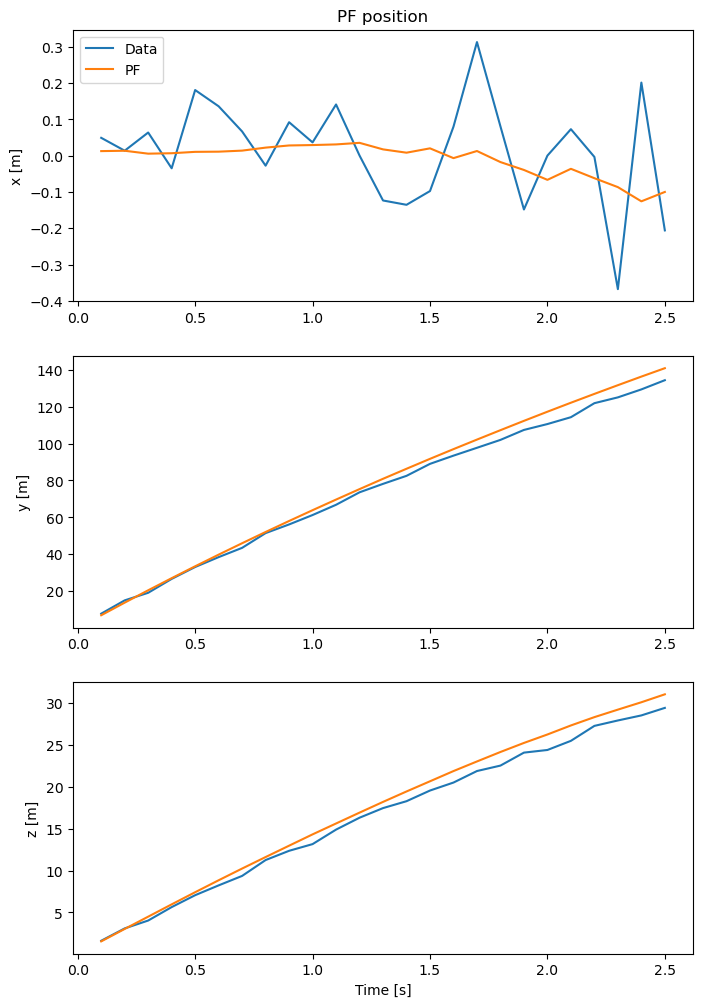

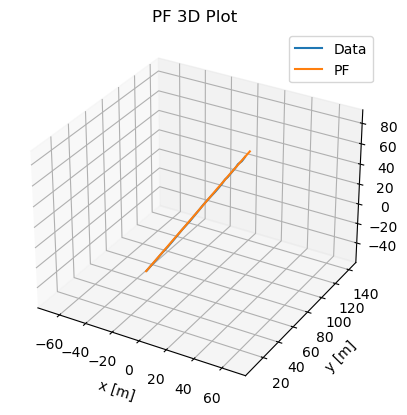

In [26]:

if plot_pf_flag:
    # ----- Plot UKF -----
    # Create subplots
    fig, axs = plt.subplots(3, 1, figsize=(8, 12))

    # Plot x, y, z
    axs[0].plot(t, x, label="Data")
    axs[0].plot(t, xPF[0, :], label="PF")
    axs[0].set_title("PF position")
    axs[0].set_ylabel("x [m]")
    axs[0].legend()

    axs[1].plot(t, y)
    axs[1].plot(t, xPF[1, :])
    axs[1].set_ylabel("y [m]")

    axs[2].plot(t, z)
    axs[2].plot(t, xPF[2, :])
    axs[2].set_ylabel("z [m]")
    axs[2].set_xlabel("Time [s]")

    # Save the figure
    # plt.savefig("figures/problem2_PF_plots.png")

    # Plot 3D trajectory
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.plot(x, y, z, label="Data")
    ax.plot(xPF[0, :], xPF[1, :], xPF[2, :], label="PF")
    ax.set_title("PF 3D Plot")
    ax.set_xlabel("x [m]")
    ax.set_ylabel("y [m]")
    ax.set_zlabel("z [m]")
    set_axes_equal(ax)
    ax.legend()

    # Save the 3D plot
    # plt.savefig("figures/problem2_PF_3d.png")

    # Show the plots
    plt.show()